## Homework

### Imports

In [59]:
import os
from typing import List

import joblib
import matplotlib.pyplot as plt
import polars as pl
import sqlalchemy
from pgvector.sqlalchemy import Vector
from PIL import Image
from sentence_transformers import SentenceTransformer
from sqlalchemy import Integer, String, create_engine
from sqlalchemy.engine import URL
from sqlalchemy.orm import DeclarativeBase, Mapped, Session, mapped_column
from tqdm.notebook import tqdm


### Paths and consts

In [29]:
DEVICE = "cpu"

In [40]:
METADATA_PATH = os.path.join(
    "data", "abo-images-small", "images", "metadata", "images.csv"
)

IMAGES_PATH = os.path.join(
    "data",
    "abo-images-small",
    "images",
    "small",
)

### 1. Dataset preparation

In [43]:
def extract_image_paths(metadata_path: str, min_pixes: int = 1000) -> List[str]:
    metadata_df = pl.read_csv(metadata_path)

    return (
        metadata_df.filter(
            (pl.col("height") >= min_pixes) & (pl.col("width") >= min_pixes)
        )
        .with_columns(
            (pl.lit(os.path.join(IMAGES_PATH, "")) + pl.col("path")).alias("path")
        )
        .get_column("path")
        .to_list()
    )

In [44]:
image_paths = extract_image_paths(METADATA_PATH)

print(image_paths[:3])

['data/abo-images-small/images/small/46/4689906d.png', 'data/abo-images-small/images/small/0c/0cd7596c.jpg', 'data/abo-images-small/images/small/e6/e602a9af.jpg']


### 2. Model Selection and Understanding

**vector length**: 512

**model_type**: Model uses a ViT-B/32 Transformer architecture as an image encoder and uses a masked self-attention Transformer as a text encoder.

Meaning of model name:
- **vit** - means Vision Transformer
- **B** - Base version of model -> medium amount of parameters
- **32** - Patch size 32x32 - 32x32 is single 'token' for model

### 3. Database Setup

Using db from lab

In [21]:
db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5432,
    database="similarity_search_service_db",
)

In [24]:
class Base(DeclarativeBase):
    __abstract__ = True


class Img(Base):
    __tablename__ = "images"
    VECTOR_LENGTH = 512

    id: Mapped[int] = mapped_column(Integer, primary_key=True)
    image_path: Mapped[str] = mapped_column(String(400))
    embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))


In [25]:
engine = create_engine(db_url)
Base.metadata.create_all(engine)

### 3. Image vectorization


In [56]:
MAX_IMAGES = 100
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)

In [38]:
model = SentenceTransformer("clip-ViT-B-32", device=DEVICE)

In [34]:
def batched(iterable, batch_size):
    for i in range(0, len(iterable), batch_size):
        yield iterable[i : i + batch_size]

In [57]:
def insert_images(engine, images: List[Img]):
    with Session(engine) as session:
        session.add_all(images)
        session.commit()


def vectorize_images(engine, model, image_paths):
    with tqdm(total=MAX_IMAGES) as pbar:
        processed = 0
        for images_paths_batch in batched(
            image_paths, batch_size=100
        ):  # finish (suggestion - use `batched`)
            images = [Image.open(path) for path in images_paths_batch]

            # calculate embeddings
            embeddings = model.encode(images)

            # create Img instances for all images in batch
            imgs = []
            for i in range(len(images)):
                img = Img(image_path=images_paths_batch[i], embedding=embeddings[i])
                imgs.append(img)

            # insert all batch images
            insert_images(engine, imgs)

            # update pbar
            pbar.update(len(images))
            processed += len(images)

            if processed >= MAX_IMAGES:
                break

In [58]:
vectorize_images(engine, model, image_paths)

  0%|          | 0/100 [00:00<?, ?it/s]

### 3. Search and results display

In [70]:
class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int):
        found_image_paths = self.find_similar_images(image_description, k)
        self.display_images(found_image_paths, k)

    def find_similar_images(self, image_description: str, k: int):
        desc_embedding = self.model.encode(
            image_description
        )  # calculate embedding of image_description

        # remember about session and commit
        with Session(engine) as session:
            result = session.execute(
                sqlalchemy.select(Img.image_path)
                .order_by(Img.embedding.cosine_distance(desc_embedding))
                .limit(k),
            ).scalars()

            return list(result)

    def display_images(self, image_paths, k):
        _, axes = plt.subplots(1, k, figsize=(15, 5))

        for i, img_path in enumerate(image_paths):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i + 1}")

        plt.show()

In [71]:
search = ImageSearch(engine, model)

## Experiments

Experiment is to find top images based on how much imagees are saved: 100, 1000, 10000. Expectation is that for 10k the results will be the best. 

In [ ]:
queries = ["Ca"]

# TODO

### Experiment with only 100

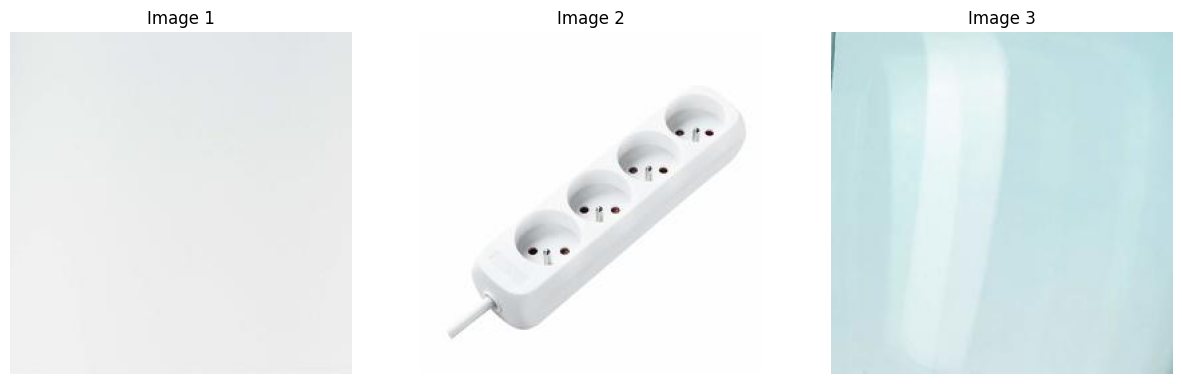

In [74]:
desc1 = "I want a dog"

search(desc1, k=3)